# Проверка гипотез по увеличению выручки в интернет-магазине — оценить результаты A/B теста

**Описание проекта**

Отдела маркетинга крупного интернет-магазина подготовил список гипотез для увеличения выручки.

Задача - приоритизировать подготовленные гипотезы для увеличения выручки интернет-магазина, запустить A/B-тест и проанализировать результаты.

**Описание данных**

Файл /datasets/hypothesis.csv содержит 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort, описание файла:

* Hypothesis — краткое описание гипотезы;

* Reach — охват пользователей по 10-балльной шкале;

* Impact — влияние на пользователей по 10-балльной шкале;

* Confidence — уверенность в гипотезе по 10-балльной шкале;

* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv, описание файла:

* transactionId — идентификатор заказа;

* visitorId — идентификатор пользователя, совершившего заказ;

* date — дата, когда был совершён заказ;

* revenue — выручка заказа;

* group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv, описание файла:

* date — дата;

* group — группа A/B-теста;

* visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

## Подготовка и предобработка данных

Импортируем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats
from scipy import stats as st

Прочитаем данные из csv-файлов и сохраним их в соответствующие переменные:

In [2]:
hypothesis, orders, visitors = (
    pd.read_csv('hypothesis.csv'),
    pd.read_csv('orders.csv'),
    pd.read_csv('visitors.csv')
)

### Рассмотрим датафрейм `hypothesis`

Выведем датафрейм с гипотезами, подготовленными отделом маркетнга:

In [3]:
pd.options.display.max_colwidth = 130
display(hypothesis.head())

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Все названия столбцов начинаются с прописной буквы, необходимо привести их к нижнему регистру.

Приведем названия столбцов к нижнему регистру:

In [4]:
hypothesis.columns = (
    hypothesis.columns
    .str.lower()
)
display(hypothesis.head())

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Выведем основную информацию о датафрейме с помощью метода `info()`:

In [5]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В датафрейме `hypothesis` количество строк во всех столбцах соответствует размеру датафрейма, пропуски отсутствуют, типы данных в столбцах соответствуют содержимому.

### Рассмотрим датафрейм `orders`

Выведем первые 5 строчек датафрейма датафрейма `orders` на экран:

In [6]:
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В названиях столбцов `transactionId` и `visitorsId` отсутствует разделительное нижнее подчеркивание, а также id с прописной буквы. Нужно привести к змеиному и нижнему регистру.

Приведем названия столбцов к корректному виду:

In [7]:
orders.columns = [name.replace('Id', '_id') for name in orders.columns.values]
display(orders.head())

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Выведем основную информацию о датафрейме с помощью метода `info()`:

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Количество строк соответствует размеру датафрейма, пропуски отсутствуют.

В столбце с датой тип данных не соответствует - object вместо datetime.

Преобразуем тип данных в столбце 'date':

In [9]:
orders['date'] = pd.to_datetime(orders['date'])
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Проверим на наличие неявных дубликатов:

In [10]:
orders.duplicated().sum()

0

### Рассмотрим датафрейм `visits`

Выведем первые 5 строчек датафрейма датафрейма `visitors` на экран:

In [11]:
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Выведем основную информацию о датафрейме с помощью метода `info()`:

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В этом датафрейме такая же проблема - не соответсвует тип данных в столбце с датой.

Количество строк соответствует размеру датафрейма, пропуски отсутствуют.

Преобразуем тип данных в столбце 'date':

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'])
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим на наличие неявных дубликатов:

In [14]:
visitors.duplicated().sum()

0

**Вывод:** по итогу предобработки данных все датафреймы были приведены к корректному виду - названия столбцов соответствуют общепринятому виду, а типы данных соответствуют содержимому столбцов. Пропуски и дубликаты в датафреймах отсутствуют, значит, можно приступать к дальнейшему исследованию.

## Основная часть исследования

### Приоритизация гипотез

Приступим к первой части работы - приоритизации гипотез.

Для этого применим два фреймворка - ICE и RICE, и сравним их.

Фреймворк ICE учитывает такие параметры, как влияние, уверенность, усилия / простота, тогда как фреймворк RICE является модификацией ICE, и также учитывает количество пользователей, которых затронет изменение.

Рассчитаем ICE и отсортируем по убыванию:

In [15]:
hypothesis['ice'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)

hypothesis[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Вывод:** четко прослеживаются топ-5 гипотез:
1. Запустить акцию, дающую скидку на товар в день рождения;
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
5. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа.

Рассчитаем RICE и отсортируем по убыванию:

In [16]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'])

hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:** в топ-5 оказались те же гипотезы, что и рассчитанные методом ICE, однако последовательность изменилась:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
4. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
5. Запустить акцию, дающую скидку на товар в день рождения.

Они также с большим отрывом выделяются от оставшихся гипотез.

Так как разница двух методов заключается в том, что метод RICE учитывает количество пользователей, которых затронут изменения, то в дальнейшем резонно ориентироваться на данный метод.

### Анализ A/B-теста

Создадим массив уникальных пар значений дат и групп теста:

In [17]:
date_grouped = orders[['date','group']].drop_duplicates()

Соберём агрегированные кумулятивные по дням данные о заказах:

In [18]:
orders_aggregated = date_grouped.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'transaction_id' : 'nunique',
            'visitor_id' : 'nunique',
            'revenue' : 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date','group'])

display(orders_aggregated.head())

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


Получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:

In [19]:
visitors_aggregated = date_grouped.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg(
        {
            'date' : 'max',
            'group' : 'max',
            'visitors' : 'sum'
        }
    ),
    axis=1,
).sort_values(by=['date','group'])

display(visitors_aggregated.head())

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединим таблицы в одну:

In [20]:
cumulative_data = orders_aggregated.merge(
    visitors_aggregated,
    left_on=['date', 'group'],
    right_on=['date', 'group']
)

cumulative_data.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors'
]

display(cumulative_data.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### Построим график кумулятивной выручки по группам

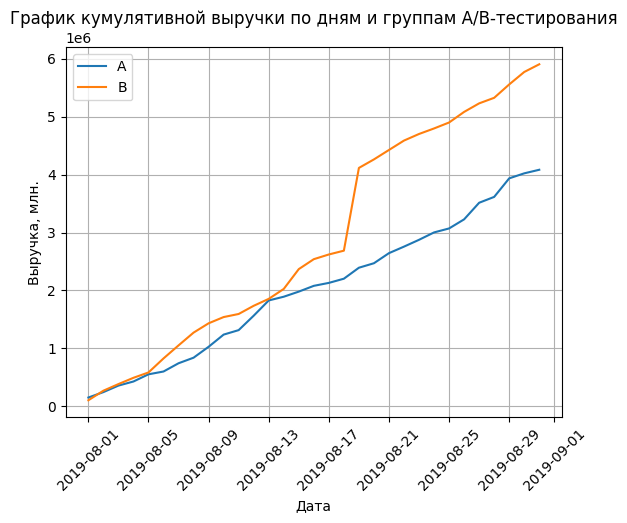

In [21]:
# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# создадим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

# построим график выручки группы А
plt.plot(
    cumulative_revenue_a['date'],
    cumulative_revenue_a['revenue'],
    label='A'
)

# построим график выручки группы B
plt.plot(
    cumulative_revenue_b['date'],
    cumulative_revenue_b['revenue'],
    label='B'
)

plt.title('График кумулятивной выручки по дням и группам A/B-тестирования')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн.')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

**Вывод**: выручка увеличивается в течение всего теста, однако на графике выручки группы B можно увидеть "всплеск", что может свидетельствовать об увеличении числа заказов, то есть конверсии, или о совершении крупных покупок, что могло увеличить средний чек. В тоже время график выручки группы A увеличивается равномерно. Также стоит отметить, что выручка группы B на протяжении всего теста была выше, чем выручка группы A.

### Построим график кумулятивного среднего чека по группам

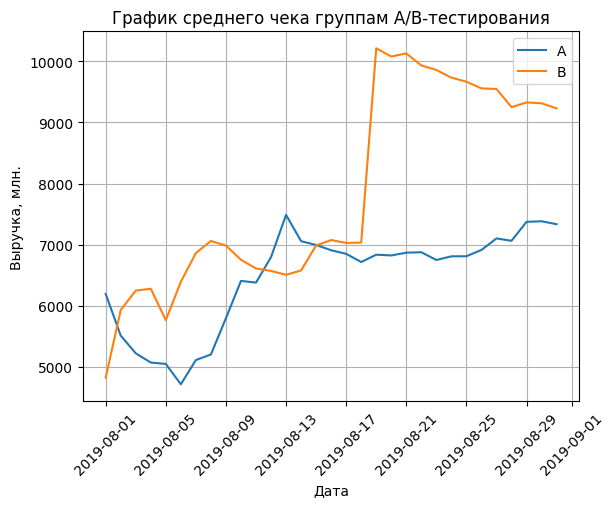

In [22]:
# построим график среднего чека группы А
plt.plot(
    cumulative_revenue_a['date'],
    cumulative_revenue_a['revenue'] / cumulative_revenue_a['orders'],
    label='A'
)

# построим график выручки группы B
plt.plot(
    cumulative_revenue_b['date'],
    cumulative_revenue_b['revenue'] / cumulative_revenue_b['orders'],
    label='B'
)

plt.title('График среднего чека группам A/B-тестирования')
plt.xlabel('Дата')
plt.ylabel('Выручка, млн.')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

**Вывод:** на графике среднего чека также можно увидеть "всплеск" группы B, в свою очередь cредний чек группы A со временем устоялся.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A

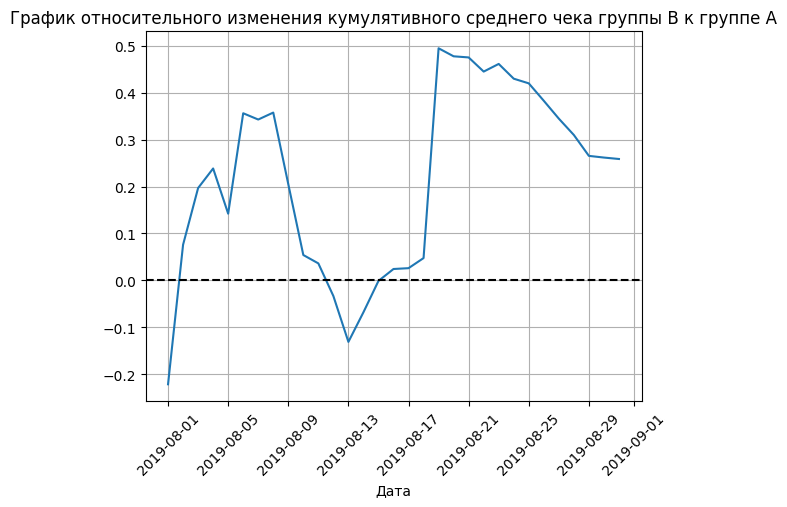

In [23]:
# объединим данные в одной датафрейме
merged_сumulative_revenue = cumulative_revenue_a.merge(
    cumulative_revenue_b,
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['_a', '_b']
)

# поcтроим график отношения средних чеков
plt.plot(
    merged_сumulative_revenue['date'],
    (merged_сumulative_revenue['revenue_b'] / merged_сumulative_revenue['orders_b']) / (merged_сumulative_revenue['revenue_a'] / merged_сumulative_revenue['orders_a']) - 1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Вывод:** в нескольких точках график различия между сегментами резко «скачет», что говорит о выбросах - крупных или дорогих заказах.

### Построим график кумулятивного среднего количества заказов на посетителя по группам

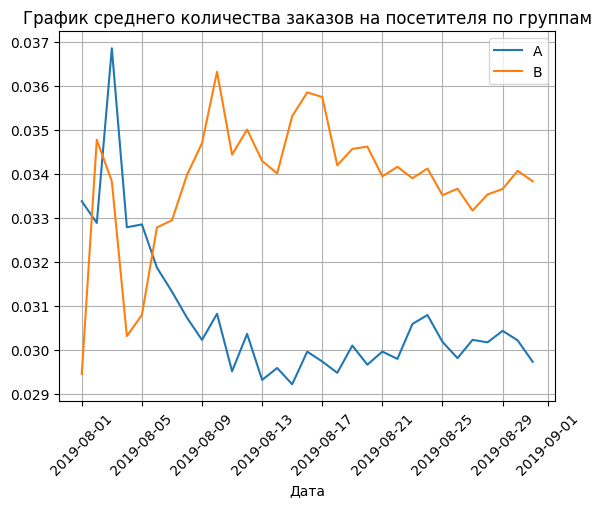

In [24]:
# посчитаем среднее количество заказов на посетителя
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']

# выделим данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# выделим данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# построим график среднего количества заказов на посетителя группы А
plt.plot(
    cumulative_data_a['date'],
    cumulative_data_a['conversion'],
    label='A'
)

# построим график среднего количества заказов на посетителя группы B
plt.plot(
    cumulative_data_b['date'],
    cumulative_data_b['conversion'],
    label='B'
)

plt.title('График среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

**Вывод:** в первые дни прослеживается большая амплитуда колебаний, где-то после 9-10 августа 2019 года конверсии обеих групп выровнялись, при этом конверсия группы B сильно лучше.

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

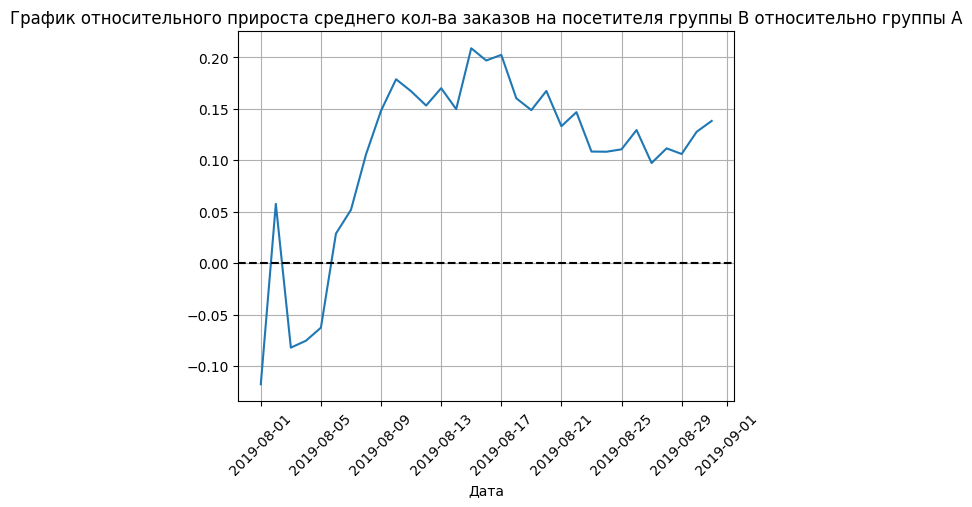

In [25]:
# объединим данные в одном датафрейме
merged_cumulative_conversions = cumulative_data_a[['date','conversion']].merge(
    cumulative_data_b[['date','conversion']],
    left_on='date',
    right_on='date',
    how='left',
    suffixes=['_a', '_b']
)

# построим график относительного прироста кумулятивного среднего количества заказов на посетителя группы B относительно группы A
plt.plot(
    merged_cumulative_conversions['date'],
    merged_cumulative_conversions['conversion_b'] / merged_cumulative_conversions['conversion_a'] - 1
)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного прироста среднего кол-ва заказов на посетителя группы B относительно группы A')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Вывод:** в начале теста группа B существенно уступала по среднему количеству заказов группе А, однако быстро вырвалась вперед, а затем медленно снижалась. Отношение среднего количества заказов на посетителя ещё не установилось, нужно проанализировать аномалии.

### Построим точечный график количества заказов по пользователям

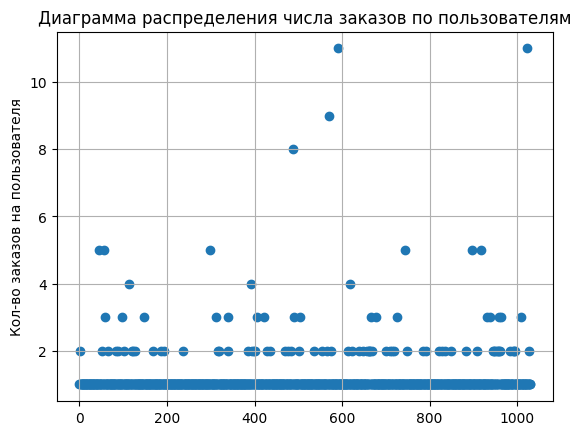

In [26]:
# создадим датафрейм с числом заказов по каждому пользователю
orders_by_users = (
    orders
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['visitor_id', 'orders']

# построим точечную диаграмму распределения числа заказов по пользователям
x_values = pd.Series(range(0, len(orders_by_users)))
plt.scatter(
    x_values,
    orders_by_users['orders']
)

plt.title('Диаграмма распределения числа заказов по пользователям')
plt.ylabel('Кол-во заказов на пользователя')
plt.grid(True)
plt.show()

**Вывод:** в основном пользователи оформляли 1-2 заказа, а все, что больше - выглядит выбросом.

### Посчитаем 95-й и 99-й перцентили количества заказов на пользователя и выберем границу для определения аномальных пользователей

In [27]:
# определим 95-й и 99-й перцентили количества заказов

np.percentile(orders_by_users['orders'], [95, 99])

array([2., 4.])

**Вывод:** 2 и больше покупок совершило только 5% пользователей, а 4 и более - 1% пользователей. В качестве границы для определения аномальных заказов примем 4 и более заказа.

### Построим точечный график стоимостей заказов

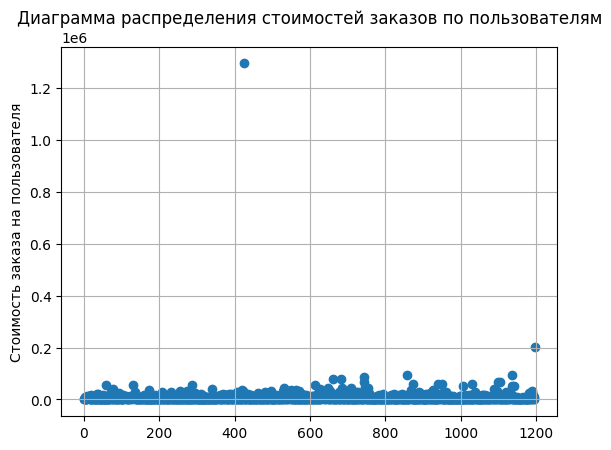

In [28]:
# построим точечную диаграмму распределения стоимостей заказов по пользователям

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(
    x_values,
    orders['revenue']
)

plt.title('Диаграмма распределения стоимостей заказов по пользователям')
plt.ylabel('Стоимость заказа на пользователя')
plt.grid(True)
plt.show()

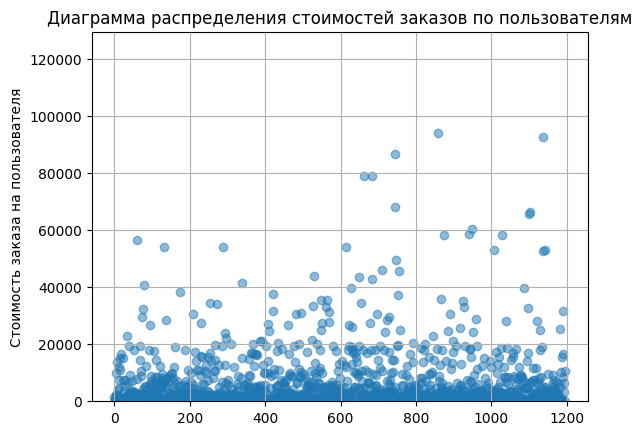

In [29]:
# построим ту же диаграмму, но ограничим график по оси Y, чтобы убрать аномалии и рассмотреть основную часть заказов

x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(
    x_values,
    orders['revenue'],
    alpha=0.5
)

plt.title('Диаграмма распределения стоимостей заказов по пользователям')
plt.ylabel('Стоимость заказа на пользователя')
plt.ylim(0, orders['revenue'].max() / 10)
plt.grid(True)
plt.show()

**Вывод:** в графике распределения стоимостей заказов выбиваются две аномалии, одна и которых могла существенно повлиять на результат.

### Посчитаем 95-й и 99-й перцентили стоимости заказов и выберем границу для определения аномальных заказов

In [30]:
# определим 95-й и 99-й перцентили стоимости заказов

np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

**Вывод:** стоимость заказа выше 28000 составляет 5%, а выше 58000 - 1% пользователей. Определим границу аномальных заказов по величине 99% перцентиля.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Сформулируем гипотезы:
* H0: различий в среднем количестве заказов между группами нет;
* H1: различия в среднем между группами есть.

In [31]:
# подготовим данные

# количество пользователей в выбранную дату в группе A
visitors_daily_a = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

# количество пользователей в выбранную дату в группе B
visitors_daily_b = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

# количество заказов в выбранную дату в группе A
orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg(
        {'transaction_id': pd.Series.nunique,
         'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_daily_a', 'revenue_per_date_a']

# количество заказов в выбранную дату в группе B
orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg(
        {'transaction_id': pd.Series.nunique,
         'revenue': 'sum'}
    )
)
orders_daily_b.columns = ['date', 'orders_daily_b', 'revenue_per_date_b']

# объединим созданные датафреймы в один общий
data = (
    orders_daily_a
    .merge(orders_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
)
display(data.head())

,date,orders_daily_a,revenue_per_date_a,orders_daily_b,revenue_per_date_b,visitors_per_date_a,visitors_per_date_b
0,2019-08-01,24,148579,21,101217,719,713
1,2019-08-02,20,93822,24,165531,619,581
2,2019-08-03,24,112473,16,114248,507,509
3,2019-08-04,16,70825,17,108571,717,770
4,2019-08-05,25,124218,23,92428,756,707


**Найдем длительность A/B-теста**

In [32]:
first_date = data[data['date'] == data['date'].min()]

In [33]:
last_date = data[data['date'] == data['date'].max()]

In [34]:
# базовая конверсия
base_conversion = first_date['orders_daily_a'] / first_date['visitors_per_date_a']
base_conversion * 100

,0
0,3.337969


In [35]:
# ожидаемая конверсия
exp_conversion = last_date['orders_daily_b'] / last_date['visitors_per_date_b']
exp_conversion * 100

,0
30,2.785515


In [36]:
# кол-во пользователей в день в среднем
count_visitors_a = data['visitors_per_date_a'].mean()
count_visitors_b = data['visitors_per_date_b'].mean()
avg_count_visitors = (count_visitors_a + count_visitors_b) / 2
avg_count_visitors

607.2903225806451

In [37]:
# создадим переменную, в которых для пользователей группы А, заказавших хотя бы 1 раз, будет число совершённых заказов
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['visitor_id', 'orders']

# создадим переменную, в которых для пользователей группы B, заказавших хотя бы 1 раз, будет число совершённых заказов
orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['visitor_id', 'orders']

In [38]:
# создадим датафрейм, в котором пользователям из группы А соответствует количество заказов группы А
sample_a = pd.concat([orders_by_users_a['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])), name='orders')],axis=0)

# создадим датафрейм, в котором пользователям из группы B соответствует количество заказов группы B
sample_b = pd.concat([orders_by_users_b['orders'],pd.Series(0, index=np.arange(data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])), name='orders')],axis=0)

In [39]:
# посчитаем статистическую значимость различия в среднем количестве заказов между группами с помощью критерия Манна-Уитни

print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))

print('Относительный прирост среднего числа заказов группы B к А: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))

P-value: 0.017
Относительный прирост среднего числа заказов группы B к А: 0.138


**Вывод:** первое число — p-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем - различие между группами есть. Однако относительный выигрыш группы B равен 13.8% — второе число в выводе.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

In [40]:
# посчитаем статистическую значимость различия в среднем чеке заказа между группами с помощью критерия Манна-Уитни

print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))

print('Относительный прирост среднего чека заказов группы B к А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

P-value: 0.729
Относительный прирост среднего чека заказов группы B к А: 0.259


**Вывод:** P-value = 0.729 значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Также, средний чек группы B выше среднего чека группы A. Однако, при таком уровне значимости наблюдаемые различия не имеют значения, так как на прирост среднего чека повлияли аномальные значения.

### Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Примем за аномальных пользователей тех, кто совершил от 4 заказов или совершил заказ дороже 58233.2 рублей. Так мы уберём 1% пользователей с наибольшим числом заказов и 1% пользователей с дорогими заказами. Сделаем срезы пользователей с числом заказов больше 4 — 'users_with_many_orders' и пользователей, совершивших заказы дороже 58233.2 — 'users_with_expensive_orders'. Объединим их в таблице 'abnormal_users'.

In [41]:
# cделаем срезы пользователей с числом заказов больше 4

users_with_many_orders = pd.concat(
    [
        orders_by_users_a[orders_by_users_a['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
        orders_by_users_b[orders_by_users_b['orders'] > np.percentile(orders_by_users['orders'], 99)]['visitor_id'],
    ],
    axis=0,
)

# сделаем срезы пользователей, совершивших заказы дороже 58233.2
users_with_expensive_orders = orders[orders['revenue'] > np.percentile(orders['revenue'], 99)]['visitor_id']

# объединим полученные датафреймы в один общий - датафрейм с очищенными данными
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(abnormal_users.head(5))
print(abnormal_users.shape[0])

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitor_id, dtype: int64
15


In [42]:
# подготовим выборку количества заказов по пользователям по группе А

sample_a_filtered = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# подготовим выборку количества заказов по пользователям по группе B
sample_b_filtered = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [43]:
# применим статистический критерий Манна-Уитни к полученным выборкам

print('Сырые данные:')
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print('Относительный прирост среднего количества заказов группы B к А: {0:.3f}'.format(sample_b.mean() / sample_a.mean() - 1))
print()
print('Очищенные данные:')
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(sample_a_filtered, sample_b_filtered)[1]))
print('Относительный прирост среднего количества заказов группы B к А: {0:.3f}'.format(sample_b_filtered.mean() / sample_a_filtered.mean() - 1))

Сырые данные:
P-value: 0.017
Относительный прирост среднего количества заказов группы B к А: 0.138

Очищенные данные:
P-value: 0.014
Относительный прирост среднего количества заказов группы B к А: 0.153


**Вывод:** результаты по среднему количеству заказов практически не изменились.

### Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

In [44]:
# применим статистический критерий Манна-Уитни к полученным выборкам

print('Сырые данные:')
print('P-value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека заказов группы B к А: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))
print()
print('Очищенные данные:')
print(
    'P-value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего чека заказов группы B к А: {0:.3f}'.format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Сырые данные:
P-value: 0.729
Относительный прирост среднего чека заказов группы B к А: 0.259

Очищенные данные:
P-value: 0.851
Относительный прирост среднего чека заказов группы B к А: -0.006


**Вывод:** P-value увеличился, но и разница между группами сократилась с 25.9% до 0.6%.

## Общий вывод и рекомендации

В ходе проектной работы было проведено исследование выручки крупного интернет-магазина с целью приоритизации гипотез по увеличению выручки, а также анализ A/B-теста.

Первым делом была проведена предобработка данных, результатом которой предоставленные датасеты были приведены к корректному виду, а также были исправлены типы данных в столбцах.

Затем была проведена приоритизация гипотез методами ICE и RICE. Так как метод RICE является модификацией метода ICE - учитывает количество пользователей, которых затронут изменения, то предпочтительнее использовать результаты приоритизации именно этого метода.

В результате применения фреймворка RICE, были выделены следующие топ-5 гипотез:
* Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
* Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
* Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
* Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию;
* Запустить акцию, дающую скидку на товар в день рождения.

Второй часть исследования был анализ A/B-теста. В ходе анализа были рассчитаны статистические значимости количества заказов и среднего чека заказа как "сырых" данных, содержащих аномалии в датафреймах, так и "очищенных" данных.

* Есть статистически значимое различие по количеству заказов между группами А и B, как «сырых», так "очищенных" данных, при этом конверсия группы B больше конверсии группы A в обоих случаях (после "очищения" данных конверсия увеличилась - с 0.138 до 0.153);
* Нет статистически значимого различия по среднему чеку между группами ни по «сырым» даным, ни по после фильтрации аномалий. Средний чек группы В "сырых" данных больше на 25.9%, по сравнению с группой А, при этом после фильтрации аномалий средний чек группы А примерно равен группе B;
* По графику относительного изменения кумулятивной конверсии группы B к группе A можно сделать вывод, что результаты группы В стабильно лучше группы А, а на графике относительного изменения кумулятивной среднего чека видно, что показатели группы B падают.

Исходя из обнаруженных фактов, тест следует продолжить. Графики конверсии показывают, что есть увеличение конверсии, хотя сам график не устоялся (не вышел на плато). Однако, тест проводился 31 день (с 2019-08-01 по 2019-08-31), а рассчитанная минимальная длительность теста составляет 38 дней. Таким образом, имеет смысл провести тест еще хотя бы неделю для того, чтобы конверсия устоялась.